In [2]:
import json

In [39]:
import pandas as pd

def analyze_parameters(data):
    # Get all unique parameter names first
    param_names = set()
    for config in data:
        param_names.update(config['parameters'].keys())
    
    # Create rows with all parameters and scores
    rows = []
    for config in data:
        params = config['parameters']
        
        # Base row with parameters
        base_row = {name: params.get(name) for name in param_names}
        
        # Add average score
        base_row['fold'] = 'average'
        base_row['score'] = config['score']
        rows.append(base_row)
        
        # Add individual fold scores
        for fold_idx, fold_score in enumerate(config['fold_scores']):
            fold_row = base_row.copy()
            fold_row['fold'] = f'fold_{fold_idx}'
            fold_row['score'] = fold_score
            rows.append(fold_row)
    
    # Convert to DataFrame
    df = pd.DataFrame(rows)
    
    # Group by each parameter to see individual effects
    param_effects = {}
    for param in param_names:
        param_effects[param] = df[df['fold'] == 'average'].groupby(param)['score'].mean()
    
    return df, param_effects

# Example usage:
# df, effects = analyze_parameters(data)
# print(effects)  # Shows how each parameter affects scores

In [41]:
with open('./params_search/results_1734219277_all.json', 'r') as f:
    data = json.loads(f.read())

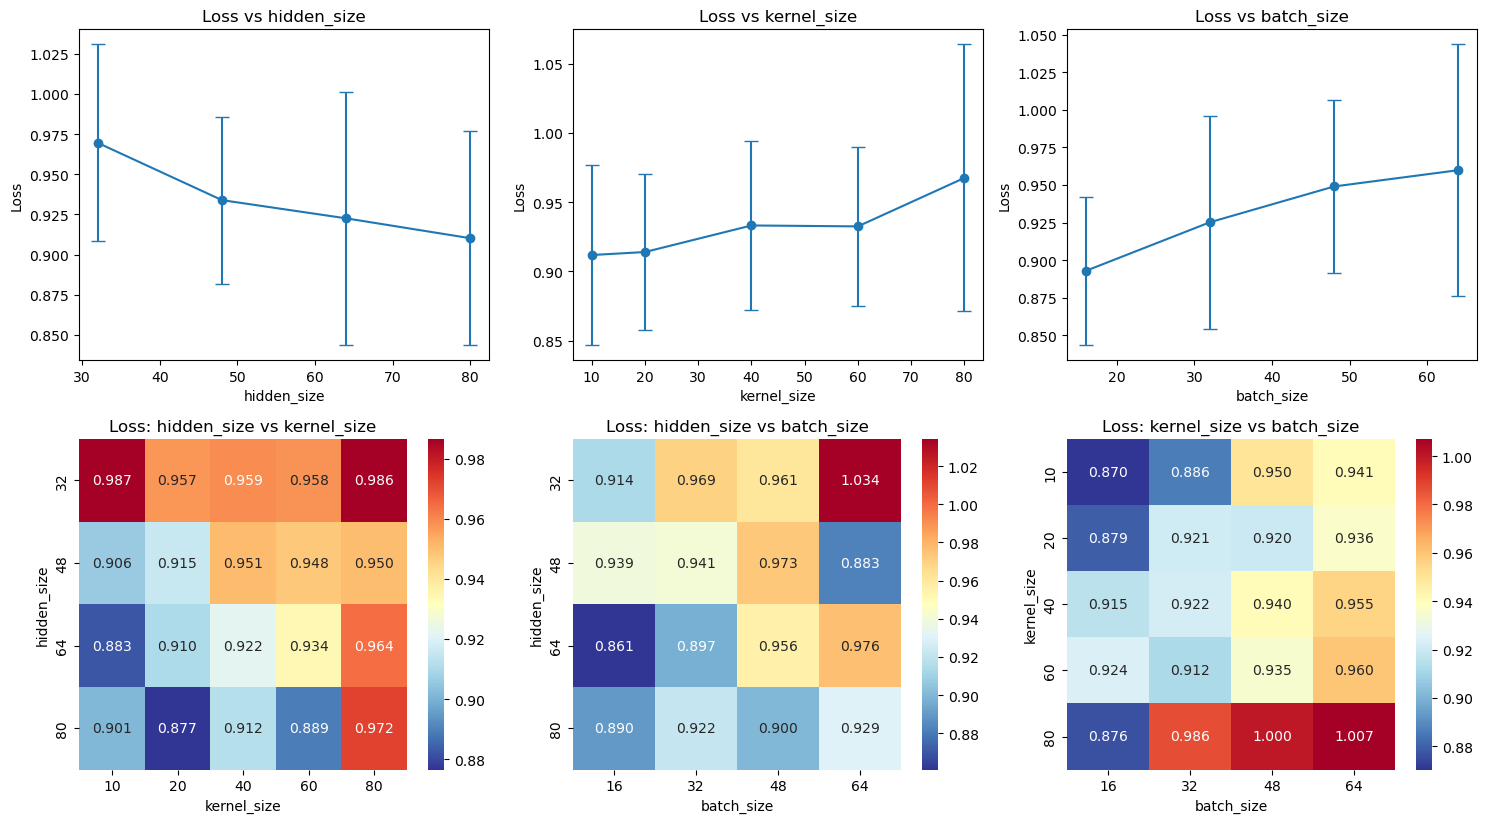

In [46]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss_parameter_relationships(data):
    # Convert to DataFrame
    rows = []
    for run in data:
        row = run['parameters'].copy()
        row['mean_loss'] = run['score']  # it's actually loss
        row['std_loss'] = np.std(run['fold_scores'])
        rows.append(row)
    
    df = pd.DataFrame(rows)
    param_names = list(data[0]['parameters'].keys())
    
    # Calculate total plots needed
    n_params = len(param_names)
    n_plots = n_params + (n_params * (n_params - 1)) // 2
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 12))
    
    # Plot individual parameter effects
    for idx, param in enumerate(param_names):
        plt.subplot(n_params, n_params, idx + 1)
        grouped = df.groupby(param)['mean_loss'].agg(['mean', 'std']).reset_index()
        plt.errorbar(grouped[param], grouped['mean'], yerr=grouped['std'], 
                    marker='o', capsize=5)
        plt.xlabel(param)
        plt.ylabel('Loss')
        plt.title(f'Loss vs {param}')
    
    # Plot pairwise relationships
    plot_idx = n_params + 1
    for i in range(len(param_names)):
        for j in range(i+1, len(param_names)):
            param1, param2 = param_names[i], param_names[j]
            
            plt.subplot(n_params, n_params, plot_idx)
            
            # Create pivot table for heatmap
            pivot = pd.pivot_table(df, values='mean_loss', 
                                 index=param1, columns=param2, 
                                 aggfunc='mean')
            
            # Plot heatmap - using 'RdYlBu_r' so red=high loss, blue=low loss
            sns.heatmap(pivot, cmap='RdYlBu_r', annot=True, fmt='.3f')
            plt.xlabel(param2)
            plt.ylabel(param1)
            plt.title(f'Loss: {param1} vs {param2}')
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.show()

# Use it
plot_loss_parameter_relationships(data)

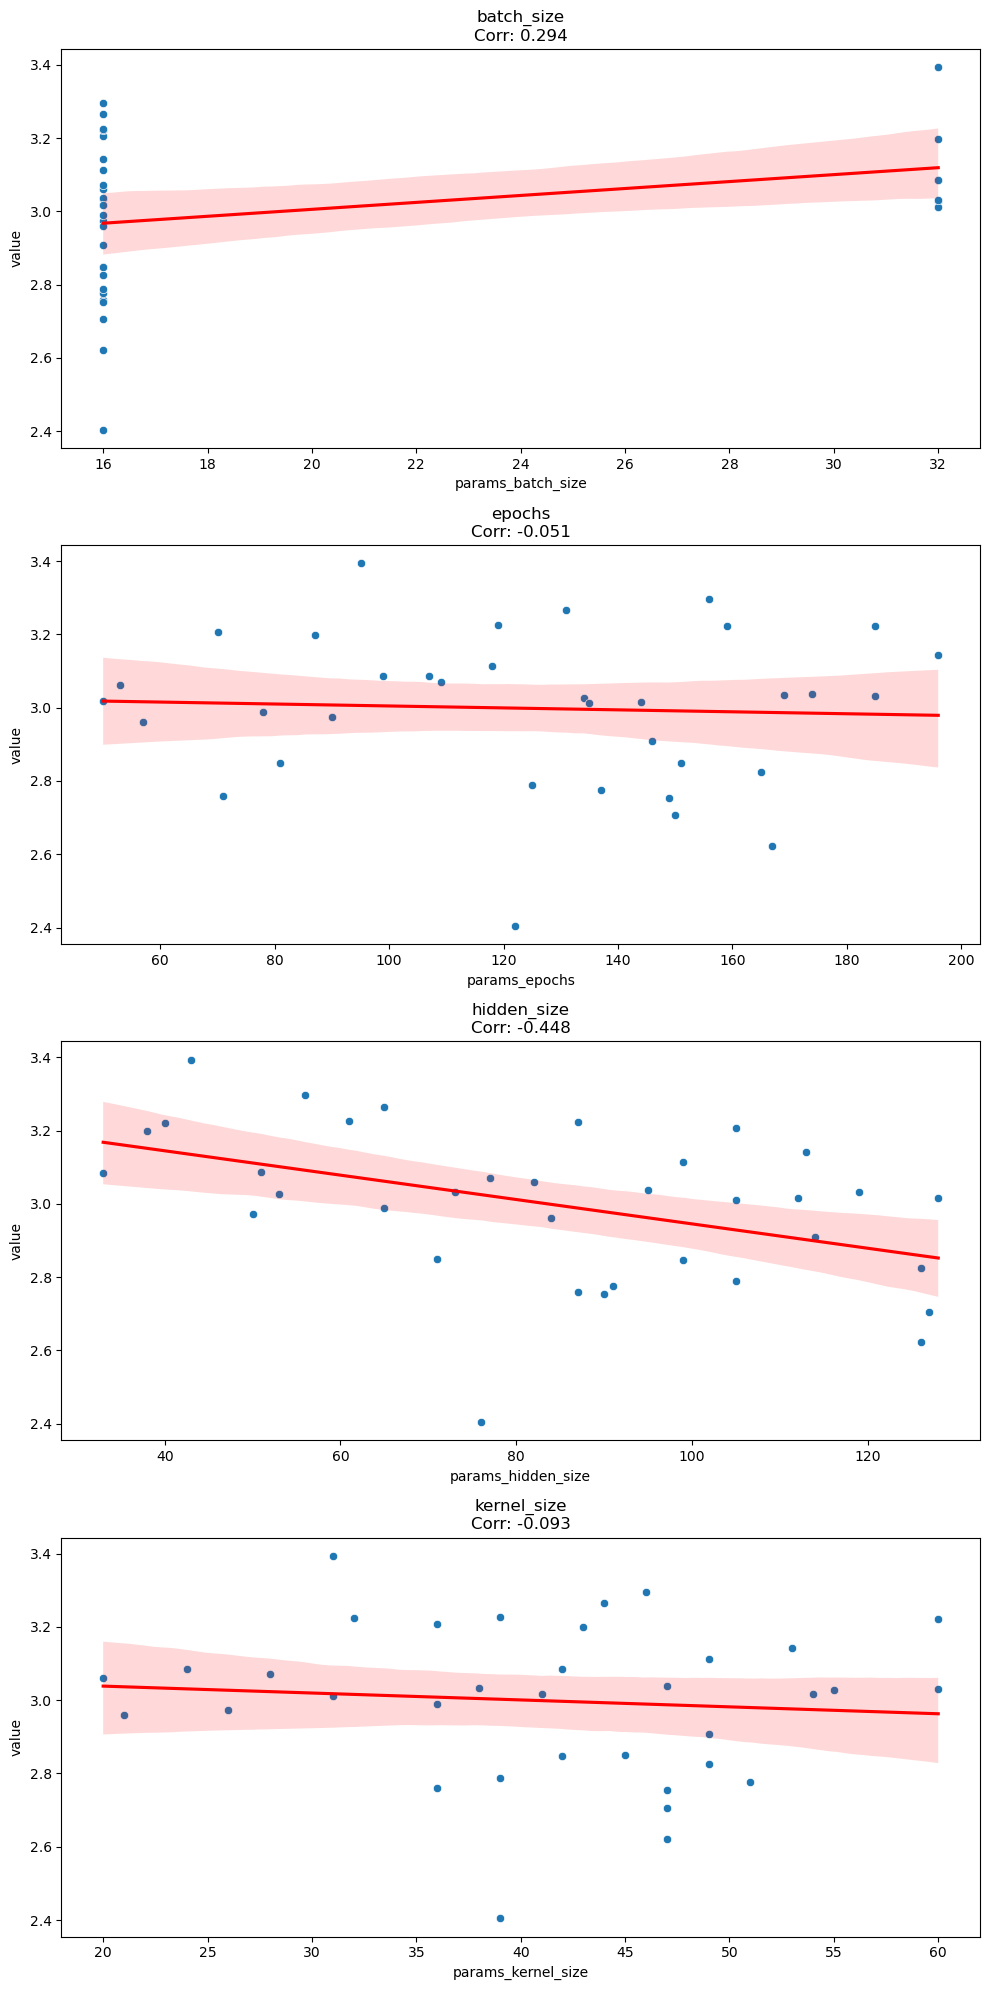

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./optuna/optuna_trials_20241215_093057.csv')
params = ['params_batch_size', 'params_epochs', 'params_hidden_size', 'params_kernel_size']

fig, axes = plt.subplots(len(params), 1, figsize=(10, 5*len(params)))

for i, param in enumerate(params):
    sns.scatterplot(data=df, x=param, y='value', ax=axes[i])
    sns.regplot(data=df, x=param, y='value', ax=axes[i], scatter=False, color='red')
    axes[i].set_title(f"{param.replace('params_', '')}\nCorr: {df[param].corr(df['value']):.3f}")

plt.tight_layout()
plt.show()

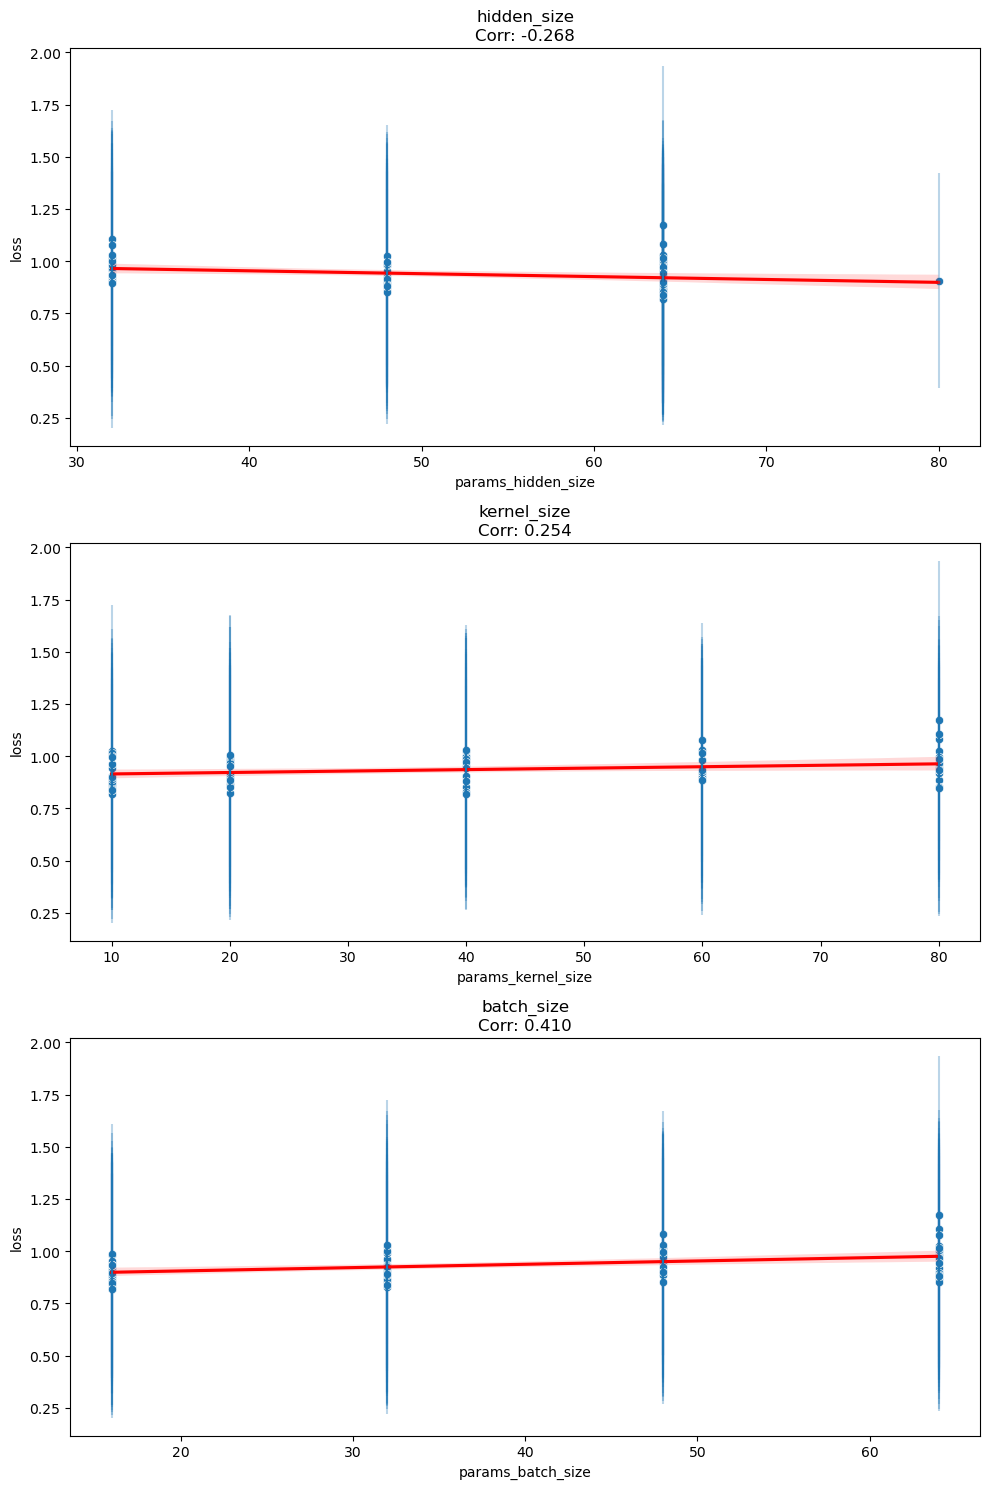

In [33]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read JSONs into DataFrame
data = []
for file in glob.glob("./params_search/results_1734219277_*.json"):
    with open(file) as f:
        exp = json.load(f)
        data.append({
            **{f'params_{k}': v for k, v in exp['parameters'].items()},
            'loss': exp['score'],
            'std': pd.Series(exp['fold_scores']).std()
        })
df = pd.DataFrame(data)

# Plot in rows
params = [col for col in df.columns if col.startswith('params_')]
fig, axes = plt.subplots(len(params), 1, figsize=(10, 5*len(params)))

for i, param in enumerate(params):
    sns.scatterplot(data=df, x=param, y='loss', ax=axes[i])
    sns.regplot(data=df, x=param, y='loss', ax=axes[i], scatter=False, color='red')
    axes[i].errorbar(df[param], df['loss'], yerr=df['std'], fmt='none', alpha=0.3)
    axes[i].set_title(f"{param.replace('params_', '')}\nCorr: {df[param].corr(df['loss']):.3f}")

plt.tight_layout()

In [19]:
df

""


# plan

- models with `forward`
- model specfic trainer to handle the training step
- model selection through hyperparameters optimization AND data augmentation: since 1 strategy of data augmentation might work better for a specific model it makes sense to optimize both jointly
- `./models/selection.py` should return actual best model and comparison results

In [16]:
import torch
from torch import nn
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## models definition

In [2]:
class RNNModel(nn.Module):
   def __init__(self, input_size, hidden_size, output_size):
       super(RNNModel, self).__init__()
       self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2) # Either GRU or LSTM
       self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output

   def forward(self, x):
       # Pass through RNN
       rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
       
       # Apply fully connected layer
       output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
       return output

In [3]:
class DeepRNNModel(nn.Module):
   def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout_prob=0.2):
       super(RNNModel, self).__init__()
       
       # Stack RNN layers
       self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
       self.fc = nn.Linear(hidden_size, output_size)

   def forward(self, x):
       # Pass through stacked RNN layers
       rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
       
       # Apply fully connected layer to the last time step's output
       output = self.fc(rnn_out)  # Use only the last time step for prediction
       return output

In [4]:
class AttentionRNNModel(nn.Module):
   def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
       super(RNNModel, self).__init__()
       
       self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
       self.attn = nn.Linear(hidden_size, hidden_size)
       self.fc = nn.Linear(hidden_size, output_size)

   def forward(self, x):
       # Pass through LSTM
       lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
       
       # Apply attention mechanism at each time step
       attn_weights = F.softmax(self.attn(lstm_out), dim=2)  # Shape: (batch_size, seq_len, hidden_size)
       weighted_out = attn_weights * lstm_out  # Apply attention: (batch_size, seq_len, hidden_size)
       
       # Pass weighted outputs through fully connected layer
       output = self.fc(weighted_out)  # Shape: (batch_size, seq_len, output_size)
       return output

In [5]:
class GRUModel(nn.Module):
   def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
       super(RNNModel, self).__init__()
       
       # GRU layer
       self.gru = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
       # Fully connected layer
       self.fc = nn.Linear(hidden_size, output_size)

   def forward(self, x):
       # Pass through GRU
       gru_out, _ = self.gru(x)  # gru_out: (batch_size, seq_len, hidden_size)
       
       # Apply fully connected layer to the last time step's output
       output = self.fc(gru_out)  # Use only the last time step for prediction
       return output

## specific trainer per model

In [6]:
class BaseTrainer:
    def train_step(self, batch):
        raise NotImplementedError

In [7]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.enabled)
print(torch.cuda.device_count())
print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
11.6
True
4
1.13.1
cuda


In [8]:
class AugmentationStrategies:
   @staticmethod
   def add_gaussian_noise(data, intensity=0.01, probability=1.0):
       augmented = data.copy()
       mask = np.random.random(len(data)) < probability
       noise = np.random.normal(0, intensity, size=data[mask].shape)
       augmented[mask] = augmented[mask] + noise
       return augmented

   @staticmethod
   def scaling_augmentation(data, min_scale=0.8, max_scale=1.2):
       augmented = data.copy()
       scales = np.random.uniform(min_scale, max_scale, size=(len(data), 1, data.shape[2]))
       augmented = augmented * scales
       return augmented

In [9]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(RNNModel, self).__init__()
        
        # Bidirectional LSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, bidirectional=True, dropout=dropout_prob)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 because of bidirectional

    def forward(self, x):
        # Pass through BiLSTM
        lstm_out, _ = self.bilstm(x)  # lstm_out: (batch_size, seq_len, hidden_size * 2)
        
        # Use the output from the last time step
        output = self.fc(lstm_out)  # Last time step output
        return output

## data preparation
- first split between train and test
  - `random_subject_split` by ratio
  - `k_fold`
- second split between train and validation
  - `k_fold`
  - `LOO`

In [10]:
nc_file = 'data/derivatives/dataset_MOTOR_60_subjects_both.nc' # hrf convoluted + block, if we want to denoise data
np.random.seed(459345)
dataset = xr.open_dataset(nc_file)

In [11]:
dataset

<xarray.Dataset>
Dimensions:  (subject: 60, voxel: 1989, time: 284)
Coordinates:
  * voxel    (voxel) int64 0 1 2 3 4 5 6 ... 1982 1983 1984 1985 1986 1987 1988
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 276 277 278 279 280 281 282 283
  * subject  (subject) object '118932_RL' '113619_LR' ... '148335_LR'
    task     object ...
Data variables:
    X        (subject, voxel, time) float64 ...
    Y        (subject, voxel, time) float64 ...
    Y_conv   (subject, voxel, time) float64 ...
Attributes:
    description:  Dataset for subject 118932, task MOTOR, acquisition RL

In [5]:
from sklearn.model_selection import GroupShuffleSplit

def create_train_test_split(dataset, test_size=0.2, random_state=None):
    subjects = dataset.subject.values
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(subjects, groups=subjects))
    
    train_subjects = subjects[train_idx]
    test_subjects = subjects[test_idx]
    
    return dataset.sel(subject=train_subjects), dataset.sel(subject=test_subjects)

In [13]:
train, test = create_train_test_split(dataset)

In [14]:
from models.bi_lstm import BiLSTMModel, BiLSTMTrainer
from models.cnn_rnn import CNNRNNModel, CNNRNNTrainer

In [15]:
models_and_trainers = [(CNNRNNModel, CNNRNNTrainer), (BiLSTMModel, BiLSTMTrainer)]

# replication

In [18]:
subjects_ids = dataset.subject.values[:3]

X_train_def, Y_train_def, Y_conv_train_def, X_test_def, Y_test_def, Y_conv_test_def, X_val_def, Y_val_def, Y_conv_val_def = get_data_tensors(subjects_ids)

Processing subject: 118932_RL
subject_data shape Frozen({'voxel': 1989, 'time': 284})
X_tensor shape torch.Size([1959, 284])
split_and_shuffle_data
Processing subject: 113619_LR
subject_data shape Frozen({'voxel': 1989, 'time': 284})
X_tensor shape torch.Size([1930, 284])
split_and_shuffle_data
Processing subject: 211417_LR
subject_data shape Frozen({'voxel': 1989, 'time': 284})
X_tensor shape torch.Size([1939, 284])
split_and_shuffle_data
pre concat
xtrain stuff torch.Size([1175, 284]) torch.Size([3496, 284, 1])
xtrain stuff torch.Size([1158, 284]) torch.Size([3496, 284, 1])
xtrain stuff torch.Size([1163, 284]) torch.Size([3496, 284, 1])
Training data shape: torch.Size([3496, 284, 1]), Test data shape: torch.Size([1168, 284, 1])
Labels (Y) shapes: Train torch.Size([3496, 284, 1]), Test torch.Size([1168, 284, 1])


In [28]:


def preprocess_subject_data(subject_data):
    """
    Preprocess the data for a given subject, including normalization, 
    handling missing values, and applying temporal shifts.

    Parameters:
    - subject_data: The data for a single subject.

    Returns:
    - X_tensor, Y_tensor, Y_conv_tensor: Preprocessed tensors for the BOLD signal and predicted signals.
    """
    #print("Data preprocess")
    
    X_subject = subject_data['X']  # Shape: [voxels, time]
    Y_subject = subject_data['Y']  # Shape: [voxels, time]
    Y_conv_subject = subject_data['Y_conv']  # Shape: [voxels, time]

    # Access time series for all voxels
    X_vals = X_subject.values
    Y_vals = Y_subject.values
    Y_conv_vals = Y_conv_subject.values

    # Remove rows with NaNs in any voxel time series
    #print("Remove rows with NaNs in any voxel time series")
    valid_mask = ~np.isnan(X_vals).any(axis=1)
    X_vals = X_vals[valid_mask]
    Y_vals = Y_vals[valid_mask]
    Y_conv_vals = Y_conv_vals[valid_mask]

    # Normalize BOLD signal (X)
    #print("Normalize BOLD signal (X)")
    X_vals = (X_vals - np.mean(X_vals, axis=1, keepdims=True)) / np.std(X_vals, axis=1, keepdims=True)

    # Convert to PyTorch tensors
    #print("Convert to PyTorch tensors")
    X_tensor = torch.tensor(X_vals, dtype=torch.float32)
    Y_tensor = torch.tensor(Y_vals, dtype=torch.float32)
    Y_conv_tensor = torch.tensor(Y_conv_vals, dtype=torch.float32)

    return X_tensor, Y_tensor, Y_conv_tensor


def split_and_shuffle_data(X_tensor, Y_tensor, Y_conv_tensor):
    """
    Shuffle and split the data into training, validation, and test sets.

    Parameters:
    - X_tensor, Y_tensor, Y_conv_tensor: Tensors for the BOLD signal and predicted signals.

    Returns:
    - X_train, X_val, X_test: Split training, validation, and test sets for BOLD signal.
    - Y_train, Y_val, Y_test: Split training, validation, and test sets for predicted signals.
    - Y_conv_train, Y_conv_val, Y_conv_test: Split training, validation, and test sets for predicted signals (Y_conv).
    """

    print("split_and_shuffle_data")
    num_samples = X_tensor.shape[0]
    indices = np.random.permutation(num_samples)
    X_tensor = X_tensor[indices]
    Y_tensor = Y_tensor[indices]
    Y_conv_tensor = Y_conv_tensor[indices]

    # Split data into train, validation, and test sets (60%, 20%, 20%)
    train_end = int(0.6 * num_samples)
    val_end = train_end + int(0.2 * num_samples)

    # Use torch.split for easier splitting
    X_train, X_val, X_test = torch.split(X_tensor, [train_end, val_end - train_end, num_samples - val_end])
    Y_train, Y_val, Y_test = torch.split(Y_tensor, [train_end, val_end - train_end, num_samples - val_end])
    Y_conv_train, Y_conv_val, Y_conv_test = torch.split(Y_conv_tensor, [train_end, val_end - train_end, num_samples - val_end])

    return X_train, X_val, X_test, Y_train, Y_val, Y_test, Y_conv_train, Y_conv_val, Y_conv_test


def concat_data(all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test, all_Y_conv_train, all_Y_conv_val, all_Y_conv_test):
    """
    Concatenate the data from all subjects into one large dataset.

    Parameters:
    - all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test, all_Y_conv_train, all_Y_conv_val, all_Y_conv_test: 
      Lists of tensors containing data for each subject.

    Returns:
    - Concatenated tensors for training, validation, and test sets.
    """
        
    X_train_def = torch.cat(all_X_train, dim=0).unsqueeze(-1)
    
    for x_train in all_X_train:
        print("xtrain stuff", x_train.shape, X_train_def.shape)

    X_test_def = torch.cat(all_X_test, dim=0).unsqueeze(-1)
    X_val_def = torch.cat(all_X_val, dim=0).unsqueeze(-1)
    Y_train_def = torch.cat(all_Y_train, dim=0).unsqueeze(-1)
    Y_test_def = torch.cat(all_Y_test, dim=0).unsqueeze(-1)
    Y_val_def = torch.cat(all_Y_val, dim=0).unsqueeze(-1)
    Y_conv_train_def = torch.cat(all_Y_conv_train, dim=0).unsqueeze(-1)
    Y_conv_test_def = torch.cat(all_Y_conv_test, dim=0).unsqueeze(-1)
    Y_conv_val_def = torch.cat(all_Y_conv_val, dim=0).unsqueeze(-1)
    
    return X_train_def, X_test_def, X_val_def, Y_train_def, Y_test_def, Y_val_def, Y_conv_train_def, Y_conv_test_def, Y_conv_val_def

def get_data_tensors(subject_ids):
    """
    Function to load, preprocess, and split data for a given list of subjects.
    It normalizes the BOLD signal (X), applies temporal shifts (if any),
    and splits the data into training, validation, and test sets.

    Parameters:
    - subject_ids: List of subject IDs to process.

    Returns:
    - X_train, Y_train, Y_conv_train: Training data tensors for BOLD signal and predicted signals.
    - X_test, Y_test, Y_conv_test: Test data tensors for BOLD signal and predicted signals.
    - X_val, Y_val, Y_conv_val: Validation data tensors for BOLD signal and predicted signals.
    """

    all_X_train, all_X_val, all_X_test = [], [], []
    all_Y_train, all_Y_val, all_Y_test = [], [], []
    all_Y_conv_train, all_Y_conv_val, all_Y_conv_test = [], [], []

    # Process data for each subject
    for sub_id in subject_ids:
        print(f"Processing subject: {sub_id}")
        subject_data = dataset.sel(subject=sub_id)

        print("subject_data shape", subject_data.sizes)
        
        # Extract time series for BOLD and predicted signals
        X_tensor, Y_tensor, Y_conv_tensor = preprocess_subject_data(subject_data)
        print("X_tensor shape", X_tensor.shape)
        
        # Shuffle and split data into train, val, and test sets
        X_train, X_val, X_test, Y_train, Y_val, Y_test, Y_conv_train, Y_conv_val, Y_conv_test = split_and_shuffle_data(
            X_tensor, Y_tensor, Y_conv_tensor)

        # Apply data augmentation on the training set
        X_train_aug, Y_train_aug, Y_conv_train_aug = X_train, Y_train, Y_conv_train

        # Append the results for each subject
        # each for cycle, shift and amplitude for augmentation can change, in order to have variability
        all_X_train.append(X_train_aug)
        all_X_val.append(X_val)
        all_X_test.append(X_test)
        all_Y_train.append(Y_train_aug)
        all_Y_val.append(Y_val)
        all_Y_test.append(Y_test)
        all_Y_conv_train.append(Y_conv_train_aug)
        all_Y_conv_val.append(Y_conv_val)
        all_Y_conv_test.append(Y_conv_test)

    # Concatenate data for all subjects
    print("pre concat")
    X_train_def, X_test_def, X_val_def, Y_train_def, Y_test_def, Y_val_def, Y_conv_train_def, Y_conv_test_def, Y_conv_val_def = concat_data(
        all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test, all_Y_conv_train, all_Y_conv_val, all_Y_conv_test
    )

    print(f"Training data shape: {X_train_def.shape}, Test data shape: {X_test_def.shape}")
    print(f"Labels (Y) shapes: Train {Y_train_def.shape}, Test {Y_test_def.shape}")

    return X_train_def, Y_train_def, Y_conv_train_def, X_test_def, Y_test_def, Y_conv_test_def, X_val_def, Y_val_def, Y_conv_val_def


In [19]:

# Training and evaluation function
def train_model(model, criterion, train_loader, validation_loader, optimizer, num_epochs, device):
    train_losses = []  # To store average training loss for each epoch
    validation_losses = []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            #print(batch_x.shape) #(batch_size,timepoints,1)
            # Forward pass
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            total_train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(avg_train_loss)  # Store train loss
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Evaluation phase
        model.eval()
        total_validation_loss = 0
        total_validation_mape = 0
        with torch.no_grad():
            for batch_x, batch_y in validation_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y)
                total_validation_loss += loss.item()
        avg_validation_loss = total_validation_loss / len(validation_loader)
        validation_losses.append(avg_validation_loss)  # Store test loss
        print(f"Epoch {epoch+1}/{num_epochs}, validation Loss: {avg_validation_loss:.4f}")
    # Plot the losses after training
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.yscale('log') 
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training and evaluation function with early stopping
def train_model_with_early_stopping(
    model, criterion, train_loader, validation_loader, optimizer, num_epochs, device, patience=5
):
    train_losses = []  # To store average training loss for each epoch
    validation_losses = []   # To store average test loss for each epoch
    best_test_loss = float('inf')  # Initialize best test loss as infinity
    patience_counter = 0  # Counter to track epochs without improvement

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Forward pass
            predictions = model(batch_x)

            # Check shapes
            if predictions.shape != batch_y.shape:
                raise ValueError(
                    f"Shape mismatch: Predictions {predictions.shape} vs Targets {batch_y.shape}. "
                    "Ensure model output matches target dimensions."
                )

            
            loss = criterion(predictions, batch_y)
            total_train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store train loss
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Evaluation phase
        model.eval()
        total_validation_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in validation_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y)
                total_validation_loss += loss.item()

        avg_validation_loss = total_validation_loss / len(validation_loader)
        validation_losses.append(avg_validation_loss)  # Store test loss
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_validation_loss:.4f}")

        # Early stopping logic
        if avg_validation_loss < best_test_loss:
            best_test_loss = avg_validation_loss
            patience_counter = 0  # Reset patience counter
            best_model_state = model.state_dict()  # Save best model state
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

        #NEW!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # Step the scheduler with the validation loss
        scheduler.step(avg_validation_loss)  # Adjust the learning rate based on validation loss


    # Restore the best model weights
    #model.load_state_dict(best_model_state)

    # Plot the losses
    plt.figure(figsize=(20, 10))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.yscale('log') 
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    return best_model_state



In [20]:
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Hyperparameters
input_size = 1  # input is a single feature per voxel
hidden_size = 64
output_size = 1  # we predict one value per timeseries per voxel
num_epochs = 100
batch_size = 32
learning_rate = 0.0001
patience=10

X_train_def.to(device);
Y_train_def.to(device);
X_val_def.to(device);
Y_val_def.to(device);

# X_train_def = apply_lowpass_filter(X_train_def)
# X_val_def = apply_lowpass_filter(X_val_def)

In [21]:
print(X_train_def.shape, Y_train_def.shape)

torch.Size([3496, 284, 1]) torch.Size([3496, 284, 1])


Epoch 10/100, Train Loss: 0.3201
Epoch 10/100, Validation Loss: 0.3162
No improvement for 1 epoch(s).
Epoch 20/100, Train Loss: 0.2822
Epoch 20/100, Validation Loss: 0.2755
Epoch 30/100, Train Loss: 0.2523
Epoch 30/100, Validation Loss: 0.2445
Epoch 40/100, Train Loss: 0.2285
Epoch 40/100, Validation Loss: 0.2174
No improvement for 1 epoch(s).
Epoch 50/100, Train Loss: 0.2083
Epoch 50/100, Validation Loss: 0.1998
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
Epoch 60/100, Train Loss: 0.1946
Epoch 60/100, Validation Loss: 0.1848
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
Epoch 70/100, Train Loss: 0.1819
Epoch 70/100, Validation Loss: 0.1729
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
Epoch 80/100, Train Loss: 0.1737
Epoch 80/100, Validation Loss: 0.1647
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s)

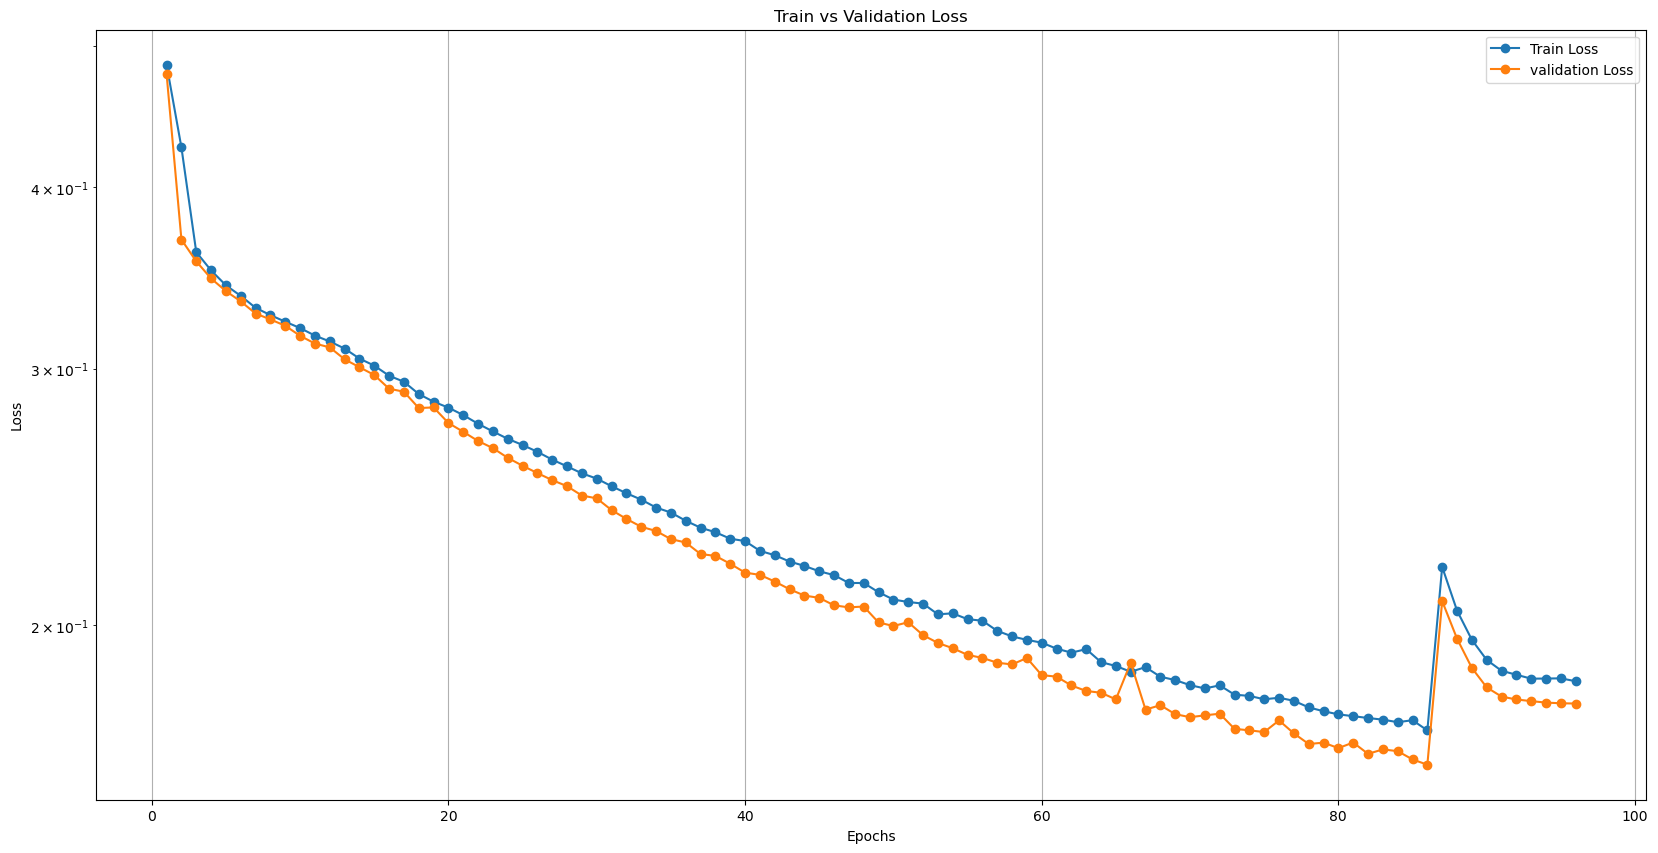

In [22]:
train_dataset = TensorDataset(X_train_def, Y_train_def)
validation_dataset = TensorDataset(X_val_def, Y_val_def)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
model = RNNModel(input_size, hidden_size, output_size).to(device)
#model = nn.DataParallel(model)
#model.to(device)
criterion = nn.L1Loss()  # MAE Loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# Train the model
#train_model(model, criterion, train_loader, test_loader, optimizer, num_epochs, device)
best_model_state = train_model_with_early_stopping(model, criterion, train_loader, validation_loader, optimizer, num_epochs, device,patience=patience)

# cleanup

In [23]:
from sklearn.model_selection import KFold
import optuna

def select_model(models_and_trainers, X_train, y_train, n_trials=100, n_folds=5):
    best_score = float('inf')
    best_results = None
    
    kf = KFold(n_splits=n_folds, shuffle=True)
    
    for ModelClass, TrainerClass in models_and_trainers:
        def objective(trial):
            # Get hyperparameters for this trial
            params = TrainerClass.get_optuna_params(trial)
            
            # Extract model params from full params
            model_params = {
                'input_size': params['input_size'],
                'hidden_size': params['hidden_size'], 
                'output_size': params['output_size'],
                'dropout_prob': params['dropout_prob']
            }
            
            model = ModelClass(**model_params)
            trainer = TrainerClass(model=model, config=params)
            
            # Cross-validation score
            fold_scores = []
            for train_idx, val_idx in kf.split(X_train):
                X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                
                trainer.train(X_fold_train, y_fold_train)
                fold_scores.append(trainer.evaluate(X_fold_val, y_fold_val))
            
            return np.mean(fold_scores)
        
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)
        
        if study.best_value < best_score:
            best_score = study.best_value
            best_results = (ModelClass, TrainerClass, study.best_params)
    
    if best_results is None:
        return None, None, None
        
    ModelClass, TrainerClass, best_params = best_results
    
    model_params = {
        'input_size': best_params['input_size'],
        'hidden_size': best_params['hidden_size'],
        'output_size': best_params['output_size'],
        'dropout_prob': best_params['dropout_prob']
    }
    
    model = ModelClass(**model_params)
    trainer = TrainerClass(model=model, config=best_params)
    
    return model, trainer, best_params

In [36]:
import numpy as np
import xarray as xr

# from augment import select_augmentation

from models.bi_lstm import BiLSTMModel, BiLSTMTrainer
from models.cnn_rnn import CNNRNNModel, CNNRNNTrainer

DATASET = 'data/derivatives/dataset_MOTOR_60_subjects_both.nc' # hrf convoluted + block, if we want to denoise data

def load_data():
    return xr.open_dataset(DATASET)

def preprocess_dataset(dataset):
    valid_mask = ~dataset.X.isnull().any(dim='time')
    print(f"Original shape: {dataset.X.shape}")
    
    dataset = dataset.isel(voxel=valid_mask.all(dim='subject'))
    
    print(f"Shape after dropping NaNs: {dataset.X.shape}")
    return dataset

dataset = preprocess_dataset(load_data())

train, test = create_train_test_split(dataset)
X_train, X_test, y_train, y_test = train.X, test.X, train.Y, test.Y

print(X_train.shape, X_test.shape)

#models_and_trainers = [(BiLSTMModel, BiLSTMTrainer), (CNNRNNModel, CNNRNNTrainer)]
#best_model, best_trainer_cls, model_params = select_model(
#    models_and_trainers, X_train, y_train, n_trials=100, n_folds=5,
#)

Original shape: (60, 1989, 284)
Shape after dropping NaNs: (60, 1869, 284)


NameError: name 'create_train_test_split' is not defined

In [ ]:
def augment_data(X_train, Y_train, Y_conv_train, shift_range=(-20, +20), amplitude_range=(0.5, 1.5), noise_std=0.1):
    """
    Augment the data by shifting and scaling the time series data.
    
    Parameters:
    - X_train, Y_train, Y_conv_train: Tensors for the BOLD signal and predicted signals (Y and Y_conv).
    - shift_range: Tuple defining the range for temporal shifts (in number of time steps).
    - amplitude_range: Tuple defining the range for amplitude scaling (scaling factor).
    
    Returns:
    - Augmented tensors for X, Y, and Y_conv.
    """
    print("Data augmentation")
    # Apply time shifts and amplitude scaling to the training set
    augmented_X = []
    augmented_Y = []
    augmented_Y_conv = []
    
    num_samples = X_train.shape[0]
    
    for i in range(num_samples):
        # 1. Apply random time shift
        shift = np.random.randint(shift_range[0], shift_range[1] + 1)  # Random shift between shift_range[0] and shift_range[1]
        shifted_X = torch.roll(X_train[i], shifts=shift, dims=0)
        shifted_Y = torch.roll(Y_train[i], shifts=shift, dims=0)
        shifted_Y_conv = torch.roll(Y_conv_train[i], shifts=shift, dims=0)

        # 2. Apply random amplitude scaling
        scale_factor = np.random.uniform(amplitude_range[0], amplitude_range[1])
        scaled_X = shifted_X * scale_factor
        scaled_Y = shifted_Y * scale_factor
        scaled_Y_conv = shifted_Y_conv * scale_factor

        # 3. Add Gaussian noise
        noise_X = torch.normal(mean=0, std=noise_std, size=scaled_X.shape).to(scaled_X.device)
        
        # Add the noise to the scaled data
        noisy_X = scaled_X + noise_X
        
        # Store augmented samples
        augmented_X.append(noisy_X)
        augmented_Y.append(scaled_Y)
        augmented_Y_conv.append(scaled_Y_conv)

    # Convert lists back to tensors
    augmented_X_tensor = torch.stack(augmented_X)
    augmented_Y_tensor = torch.stack(augmented_Y)
    augmented_Y_conv_tensor = torch.stack(augmented_Y_conv)

    return augmented_X_tensor, augmented_Y_tensor, augmented_Y_conv_tensor

## data augmentation

In [ ]:
from model_selection import prepare_bold_input, prepare_target_input

In [ ]:
print(X_train.shape, y_train.shape)

In [ ]:
y_train_t = prepare_target_input(y_train)
X_train_t = prepare_bold_input(X_train)

In [ ]:
def shift(X, y, shift_range=(-20, +20), groups=5, ratio=0.3):
    batch_size = X.shape[0]
    group_size = batch_size // groups
    
    shifted_X = X.clone()
    shifted_y = y.clone()
    
    for g in range(groups):
        start_idx = g * group_size
        end_idx = start_idx + group_size if g < groups - 1 else batch_size
        
        num_to_shift = int((end_idx - start_idx) * ratio)
        shift_indices = np.random.choice(range(start_idx, end_idx), size=num_to_shift, replace=False)
        
        for idx in shift_indices:
            shift = np.random.randint(shift_range[0], shift_range[1] + 1)
            shifted_X[idx] = torch.roll(X[idx], shifts=shift, dims=0)
            shifted_y[idx] = torch.roll(y[idx], shifts=shift, dims=0)
    
    return shifted_X, shifted_y

In [ ]:
print(X_train_t.shape, y_train_t.shape)

In [ ]:
xsh, ysh = shift(X_train_t, y_train_t, shift_range=(-100, 50), ratio=0.7)

pick = 5
voxels = np.random.choice(xsh.shape[0], size=pick, replace=False)

plt.figure(figsize=(20, 7))
plt.plot(y_train_t[voxels , :].T);
plt.plot(ysh[voxels, :].T)
plt.show()

messy temporal shift, just what the doctor ordered

In [ ]:
def temporal_scale(X, y, scale_range=(0.8, 1.2), ratio=0.3, keep_len=True):
    n_voxels, time_points, _ = X.shape
    
    if not keep_len:
        new_length = int(time_points * np.random.uniform(*scale_range))
        print("new_length", new_length)
        scaled_X = torch.nn.functional.interpolate(X.transpose(1,2), size=new_length).transpose(1,2)
        scaled_y = torch.nn.functional.interpolate(y.unsqueeze(1), size=new_length).squeeze(1)
    else:
        scaled_X, scaled_y = X.clone(), y.clone()
    
    for vox_idx in np.random.choice(range(n_voxels), size=int(n_voxels * ratio), replace=False):
        new_length = int(time_points * np.random.uniform(*scale_range)) if keep_len else scaled_X.shape[1]
        x_interp = torch.nn.functional.interpolate(X[vox_idx].T.unsqueeze(0), size=new_length).squeeze().T.unsqueeze(-1)
        y_interp = torch.nn.functional.interpolate(y[vox_idx].unsqueeze(0).unsqueeze(0), size=new_length).squeeze()
        
        if keep_len:
            if new_length < time_points:
                repeats = int(np.ceil(time_points / new_length))
                x_interp = x_interp.repeat(repeats, 1)[:time_points]
                y_interp = y_interp.repeat(repeats)[:time_points]
            else:
                x_interp = x_interp[:time_points]  # Only trim if longer
                y_interp = y_interp[:time_points]
            scaled_X[vox_idx] = x_interp
            scaled_y[vox_idx] = y_interp
        else:
            scaled_X[vox_idx] = x_interp
            scaled_y[vox_idx] = y_interp
            
    return scaled_X, scaled_y

In [38]:
xts, yts = temporal_scale(X_train_t[:500], y_train_t[:500], scale_range=(0.5, 3), ratio=0.7)

NameError: name 'temporal_scale' is not defined

In [37]:
pick = 1
voxels = np.random.choice(xts.shape[0], size=pick, replace=False)
voxels = [431]

plt.title(f"voxels {voxels}")
plt.plot(X_train_t[voxels, :].squeeze(0), label="original")
plt.plot(xts[voxels, :].squeeze(0), label="temp-scaled")
plt.legend()
plt.show()

plt.title(f"voxels {voxels}")
plt.plot(y_train_t[voxels , :].T, label="original")
plt.plot(yts[voxels, :].T, label="temp-scaled")
plt.legend()
plt.show()

NameError: name 'xts' is not defined

2x-ish amplification

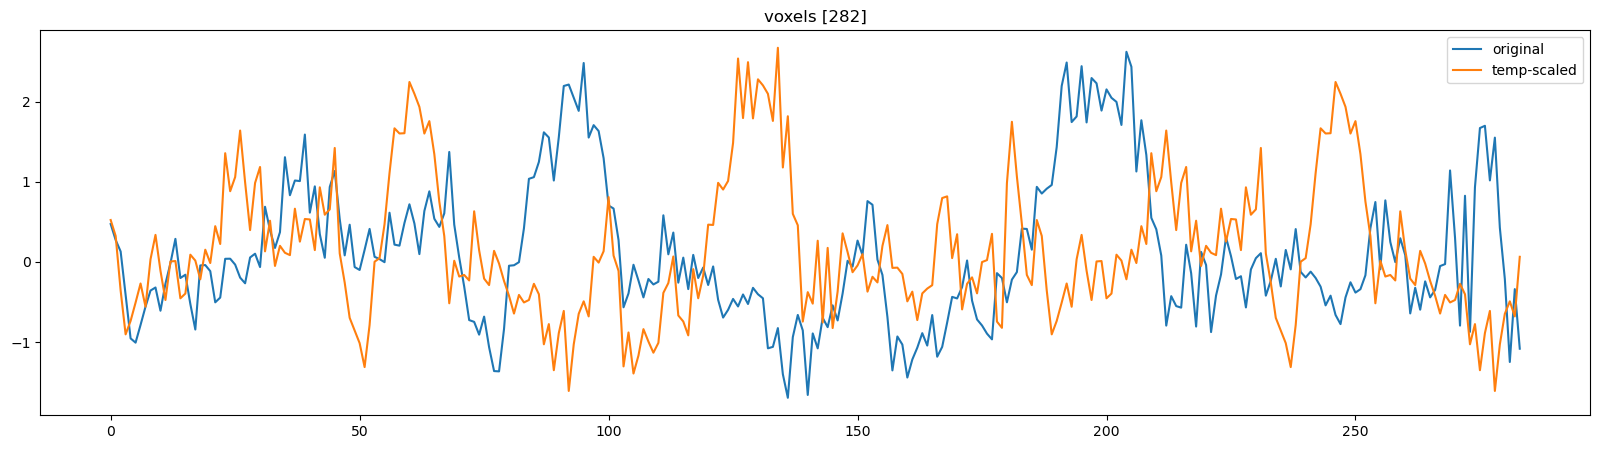

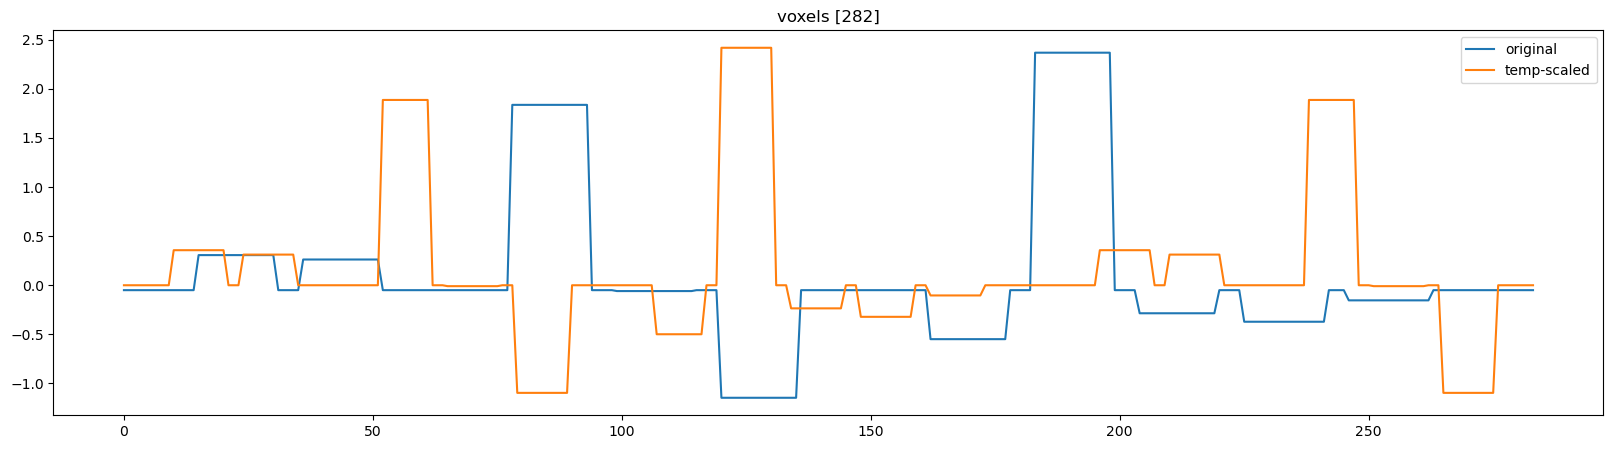

In [237]:
pick = 1
voxels = np.random.choice(xts.shape[0], size=pick, replace=False)

plt.figure(figsize=(20, 5))
plt.title(f"voxels {voxels}")
plt.plot(X_train_t[voxels, :].squeeze(2).T-0.05, label="original")
plt.plot(xts[voxels, :].squeeze(2).T, label="temp-scaled")
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.title(f"voxels {voxels}")
plt.plot(y_train_t[voxels , :].T -0.05, label="original")
plt.plot(yts[voxels, :].T, label="temp-scaled")
plt.legend()
plt.show()

In [238]:
xts_untrimmed, yts_untrimmed = temporal_scale(X_train_t[:500], y_train_t[:500], scale_range=(0.5, 2), ratio=0.7, keep_len=False)

new_length 362


In [239]:
xts_untrimmed.shape

torch.Size([500, 362, 1])

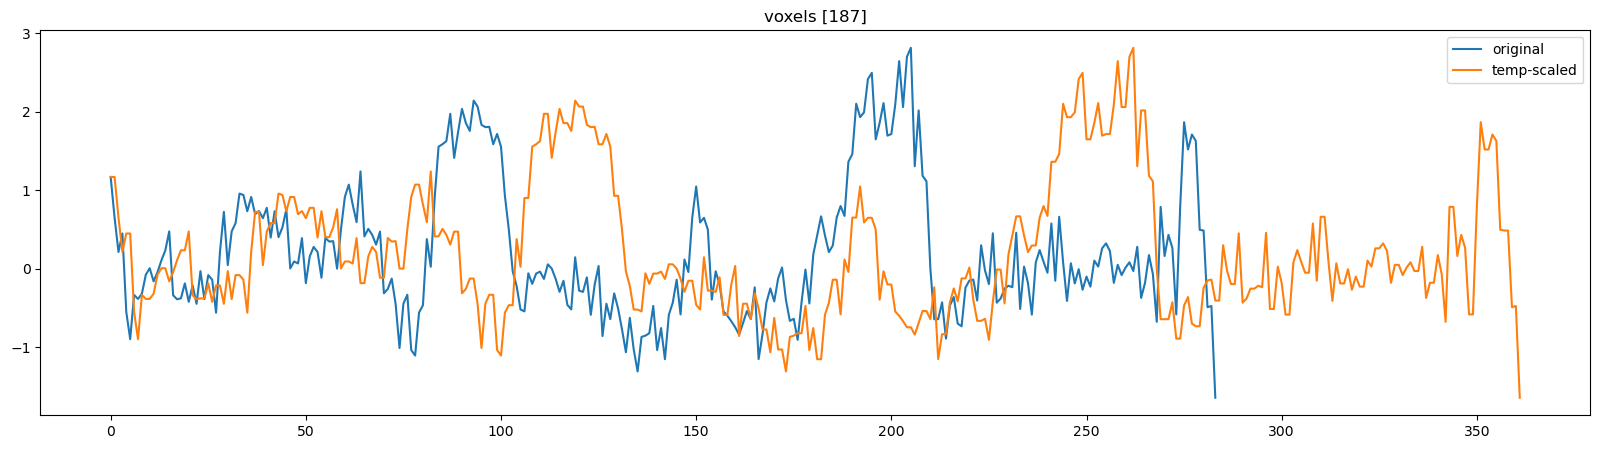

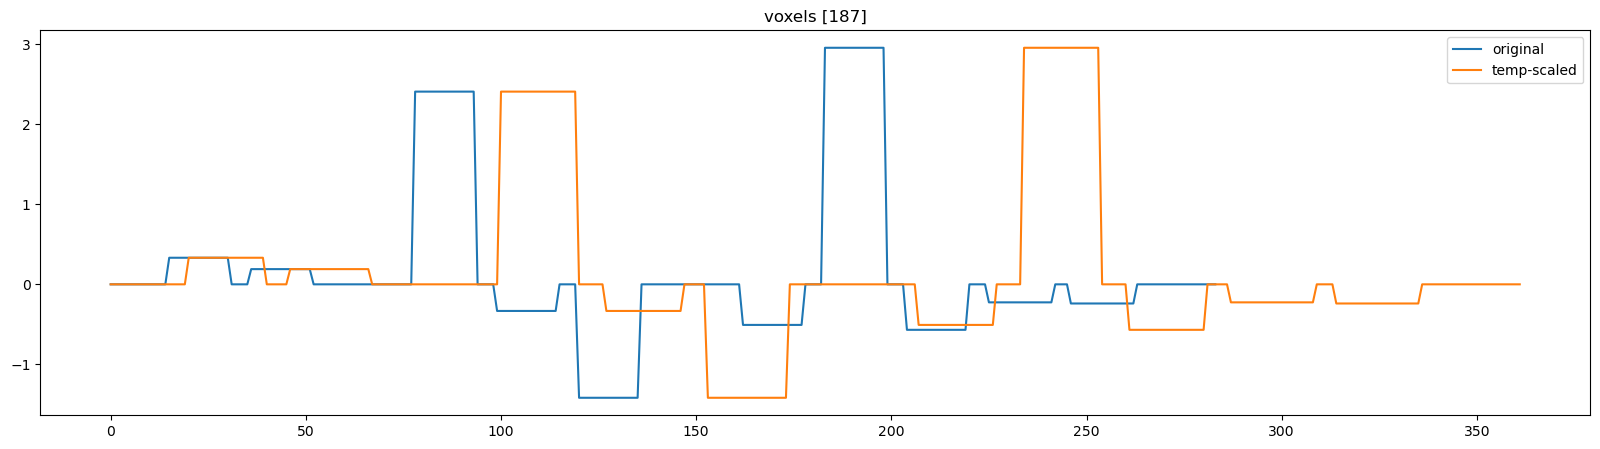

In [240]:
pick = 1
voxels = np.random.choice(xts.shape[0], size=pick, replace=False)

plt.figure(figsize=(20, 5))
plt.title(f"voxels {voxels}")
plt.plot(X_train_t[voxels, :].squeeze(2).T, label="original")
plt.plot(xts_untrimmed[voxels, :].squeeze(2).T, label="temp-scaled")
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.title(f"voxels {voxels}")
plt.plot(y_train_t[voxels , :].T, label="original")
plt.plot(yts_untrimmed[voxels, :].T, label="temp-scaled")
plt.legend()
plt.show()

In [254]:
xts_untrimmed, yts_untrimmed = temporal_scale(X_train_t[:500], y_train_t[:500], scale_range=(0.5, 0.7), ratio=0.7, keep_len=False)

new_length 184


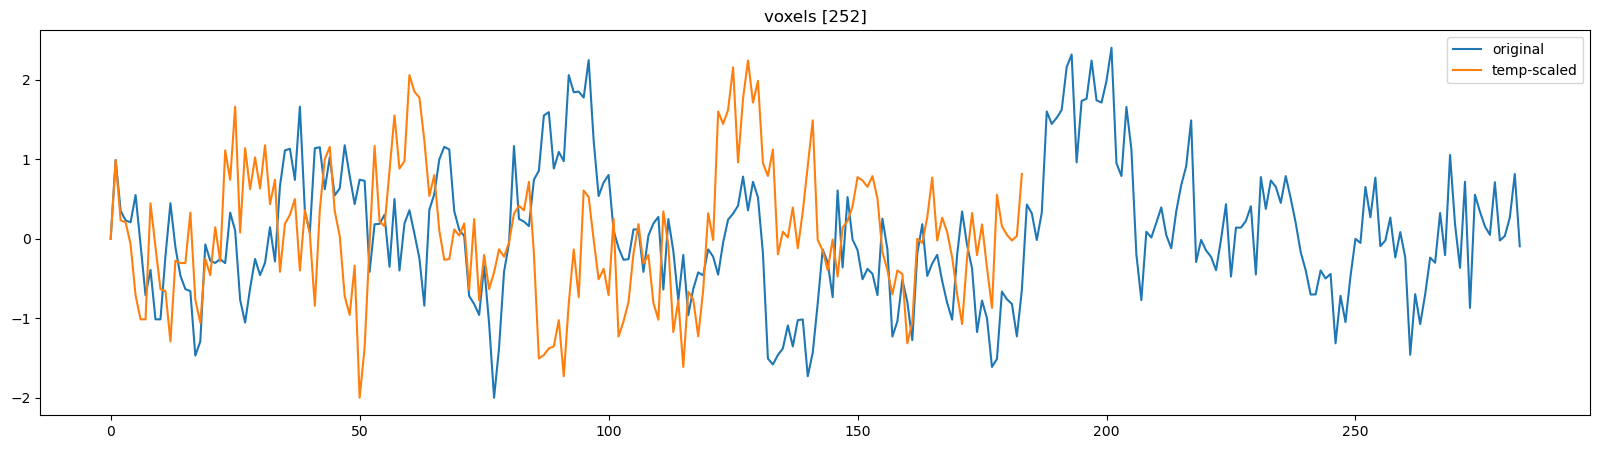

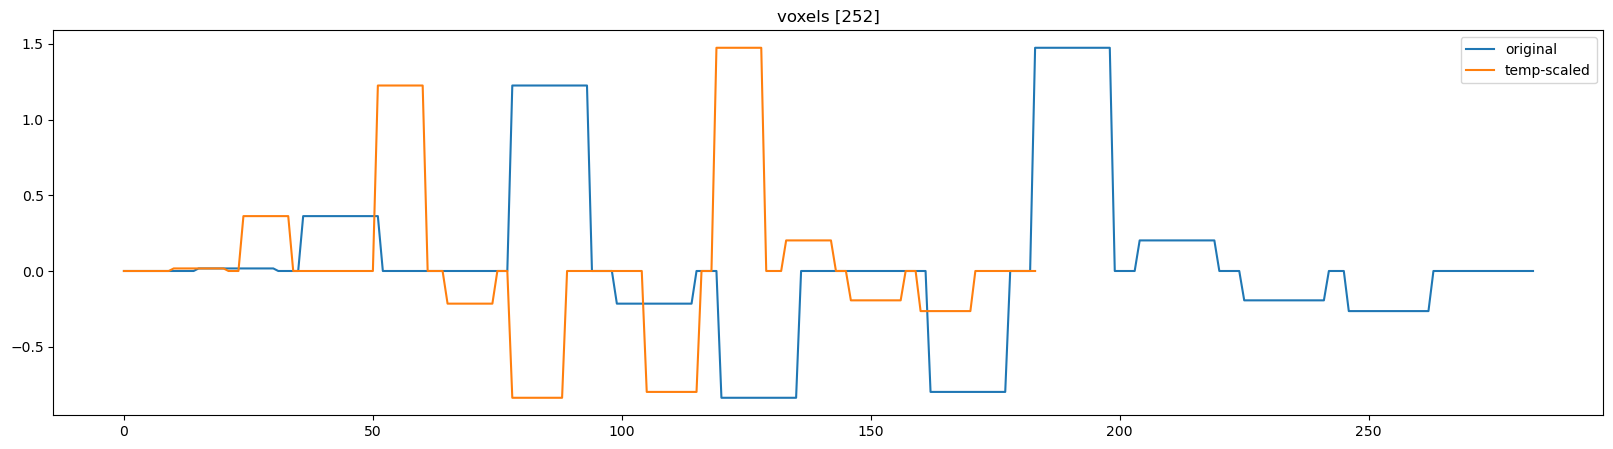

In [255]:
pick = 1
voxels = np.random.choice(xts.shape[0], size=pick, replace=False)

plt.figure(figsize=(20, 5))
plt.title(f"voxels {voxels}")
plt.plot(X_train_t[voxels, :].squeeze(2).T, label="original")
plt.plot(xts_untrimmed[voxels, :].squeeze(2).T, label="temp-scaled")
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.title(f"voxels {voxels}")
plt.plot(y_train_t[voxels , :].T, label="original")
plt.plot(yts_untrimmed[voxels, :].T, label="temp-scaled")
plt.legend()
plt.show()

In [256]:
from run import oneshot

In [257]:
oneshot()

Original shape: (30, 1989, 284)
Shape after dropping NaNs: (30, 1893, 284)
Xs torch.Size([53004, 284, 1]) torch.Size([3786, 284, 1])
ys torch.Size([53004, 284]) torch.Size([3786, 284])
{
  "batch_size": 128,
  "dropout_prob": 0.4,
  "epochs": 80,
  "optimizer": "adam",
  "optimizer_params": {
    "lr": 0.00030706278416962776
  }
}
running on cuda:2
X_train torch.Size([53004, 284, 1])
learning params: batch_size=128, n_epochs=80
Epoch 0, Loss: 0.441481
Epoch 10, Loss: 0.260340
Epoch 20, Loss: 0.224951
Epoch 30, Loss: 0.201607
Epoch 40, Loss: 0.183692
Epoch 50, Loss: 0.176052
Epoch 60, Loss: 0.157457
Epoch 70, Loss: 0.148261


OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 GiB (GPU 2; 23.50 GiB total capacity; 1.32 GiB already allocated; 15.19 GiB free; 1.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF